# Performance analysis

In [279]:
import numpy as np 
import pandas as pd 
import matplotlib. pyplot as plt  
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore") 
import re

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from tabulate import tabulate
from collections import  Counter


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\megia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\megia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\megia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\megia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preparing data/outputs

In [262]:
def preprocess_data(dataframe : pd.DataFrame, colname : str, remove_stopwords = False):

    df1=dataframe.copy()
    
    df1 = df1.astype({colname: str})   
    df1  = df1.replace(r'\r+|\n+|\t+',' ', regex=True)
    
    #Remove special characters
    df1[colname] = df1[colname].apply(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(x)))
    df1[colname] = df1[colname].str.replace('[^\w\s]','')
    df1[colname] = df1[colname].str.replace('\d+', '')
    df1[colname] = df1[colname].apply(lambda x: re.sub(' +', ' ', str(x)))

    return df1

In [263]:
#Load data
data = pd.read_csv("C:/Users/megia/Desktop/PML/data/bias_madlibs_77k.csv")
data['toxic'] = [1 if lab == 'BAD' else 0 for lab in data.loc[:,'Label']]
data = pd.concat([data['Text'] , data['toxic']], axis = 1)
data = data.rename(columns = {'Text': 'comment_text'})


df_tst = data.copy()
df_tst_labels = df_tst['toxic']

outputs_csv = pd.read_csv("preds_unintended_bias.csv")
outputs_csv_db = pd.read_csv("preds_db_unintended_bias.csv")

#df_bert = pd.concat([df_tst, outputs_csv['toxic'].rename(columns = {'toxic':'bert_toxic'})], axis =1)
#df_dbert = pd.concat([df_tst, outputs_csv_db['toxic'].rename(columns = {'toxic':'dbert_toxic'})], axis =1)


classes = ['toxic']

In [274]:
data.sample(15)

,comment_text,toxic
49152,Ziv is a great female,0
57892,Zoe is a ugly paralyzed,1
63970,Mateo is a excellent millenial,0
41941,Anastasiya is a lovely taoist,0
44859,Abdul is a gracious paralyzed,0
53731,Nithum is a gracious young,0
43329,Dlshad is a vile elderly,1
3673,Hoshi is a wonderful latinx,0
76337,You are a fucked designer,1
10843,Lucas is a fantastic younger,0


In [264]:
df_bert = outputs_csv[['comment_text','toxic']]
df_bert = df_bert.rename(columns = {'toxic': 'bert_toxic'})
df_bert = pd.concat([df_bert['comment_text'], df_tst['toxic'], df_bert['bert_toxic']], axis =1)


In [265]:
df_dbert = outputs_csv_db[['comment_text','toxic']]
df_dbert = df_dbert.rename(columns = {'toxic': 'dbert_toxic'})
df_dbert = pd.concat([df_dbert['comment_text'], df_tst['toxic'], df_dbert['dbert_toxic']], axis =1)


In [266]:
# COUNT SAMPLES
nr_toxic = df_bert[classes].apply(pd.value_counts)
nr_toxic = nr_toxic.values.tolist()

print('total:', len(df_bert), 'toxic / nontoxic:', nr_toxic)

total: 76564 toxic / nontoxic: [[38282], [38282]]


## Dataset is pretty unbiased w.r.t. identity terms

In [270]:
def filter_frame(frame, keyword=None, length=None):
    """Filters DataFrame to comments that contain the keyword as a substring and fit within length."""
    if keyword:
        frame = frame[frame['comment_text'].str.contains(keyword, case=False)]
    if length:
        frame['length'] = [len(comment) for comment in frame['comment_text']]
        frame = frame[frame['length'] <= length]
    return frame

def class_balance(frame, keyword, length=None):
    """Returns the fraction of the dataset labeled toxic."""
    frame = filter_frame(frame, keyword, length)
    if len(frame)!= 0:
        return len(frame[frame['toxic']==1]) / len(frame)
    return 0.0

def class_balance_in_preds(frame, keyword, length=None):
    """Returns the fraction of the dataset labeled toxic."""
    frame = filter_frame(frame, keyword, length)
    if len(frame)!= 0:
        return len(frame[frame['pred_toxic']>0.5]) / len(frame)
    return 0.0

TEST_TERMS = ['lesbian','gay', 'bisexual', 'transgender','trans','queer','lgbt','lgbtq','homosexual','straight',
         'heterosexual', 'male','female', 'nonbinary', 'african','african american', 'black', 'white','european', 'hispanic', 'latino', 'latina', 
         'latinx','mexican','canadian', 'american', 'asian', 'indian', 'middle eastern','chinese','japanese','christian','muslim', 'jewish', 'buddhist',
         'catholic','protestant','sikh', 'taoist', 'older', 'young', 'younger','teenage', 'millenial','middle aged', 'elderly', 'blind','deaf', 'paralyzed']
print(len(TEST_TERMS))
num_terms = []
print('TEST SET')
print('overall class balance        {:.1f}%\t{} examples'.format(
    100 * class_balance(data, keyword=None), len(data)))

for fraction, num, term in sorted((class_balance(data, term),
                                   len(filter_frame(data, term)),
                                   term)
                                  for term in TEST_TERMS):
    num_terms.append(num)
    print('class balance for {:10s} {:.1f}%\t{} examples'.format(term, 100 * fraction, num))

49
TEST SET
overall class balance        50.0%	76564 examples
class balance for african american 50.0%	1514 examples
class balance for asian      50.0%	1514 examples
class balance for bisexual   50.0%	1514 examples
class balance for black      50.0%	1514 examples
class balance for blind      50.0%	1514 examples
class balance for buddhist   50.0%	1514 examples
class balance for canadian   50.0%	1514 examples
class balance for catholic   50.0%	1514 examples
class balance for chinese    50.0%	1514 examples
class balance for christian  50.0%	1514 examples
class balance for deaf       50.0%	1514 examples
class balance for elderly    50.0%	1514 examples
class balance for european   50.0%	1514 examples
class balance for female     50.0%	1514 examples
class balance for gay        50.0%	1514 examples
class balance for heterosexual 50.0%	1514 examples
class balance for hispanic   50.0%	1514 examples
class balance for homosexual 50.0%	1514 examples
class balance for indian     50.0%	1514 examples

## ROC AUC

In [29]:
def roc_auc(outputs, model_name, test_labels = df_tst ,classes = ['toxic']):    
    
    roc_auc_scores = []
    
    for category in classes:
        roc_auc_scores += [roc_auc_score(test_labels[category].astype(int), outputs[category])]
    print(model_name)
    
    data = list(zip(classes, roc_auc_scores))
    col_names = ['Class', 'Score' ]
    print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))
   
    print(f"average score {sum(roc_auc_scores)/len(roc_auc_scores)}\n")
    
    return data
    
#roc_auc(outputs, 'BERT')
#roc_auc(outputs_db, 'DistilBERT')

## Calculate predictions from probabilities

In [32]:
def calc_predictions(probs = outputs_csv, y_true = df_bert, classes=classes, thresholds = None):
    
    probs = probs.reset_index(drop=True)
    y_true = y_true.reset_index(drop=True)

    predictions = pd.concat([y_true.loc[:, ['comment_text'] + classes].rename(columns = {'toxic':'true_toxic', 'severe_toxic': 'true_severe_toxic', 'obscene': 'true_obscene', 'threat': 'true_threat', 'insult': 'true_insult', 'identity_hate': 'true_identity_hate'}),
                                 probs.loc[:, classes].rename(columns = {'toxic':'prob_toxic', 'severe_toxic': 'prob_severe_toxic', 'obscene': 'prob_obscene', 'threat': 'prob_threat', 'insult': 'prob_insult', 'identity_hate': 'prob_identity_hate'})], 
                                axis=1)

    preds = pd.DataFrame(columns = classes)
    for i,category in enumerate(classes):  
        threshold = 0.5
        if thresholds!= None:
            threshold = thresholds[i]            
        preds[category] = [0 if x<threshold else 1 for x in probs[category]] 
            
    predictions = pd.concat([predictions['comment_text'], preds, predictions.iloc[:, 1:]], axis=1)
    
    return predictions

## Accuracy

In [33]:
def class_accuracy(y_probs, model_name, thresholds = None, y_true = df_bert, balanced = True, adj = False):
    
    acc = []
    y_preds = calc_predictions(probs = y_probs, y_true = y_true, thresholds = thresholds)
    for category in classes:
        if balanced:
            acc += [metrics.balanced_accuracy_score(y_true[category].astype(int),y_preds[category], adjusted = adj)]
        else: 
            acc += [metrics.accuracy_score(y_true[category].astype(int),y_preds[category])]
            
    print(model_name, 'Accuracy') 
    data = list(zip(classes, acc))
    col_names = ['Class', 'Accuracy' ]
    print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))
   
    print(f"average score {sum(acc)/len(acc)}\n")
    
    return data 


In [35]:
predictions = calc_predictions(outputs_csv)
predictions_db = calc_predictions(outputs_csv_db)

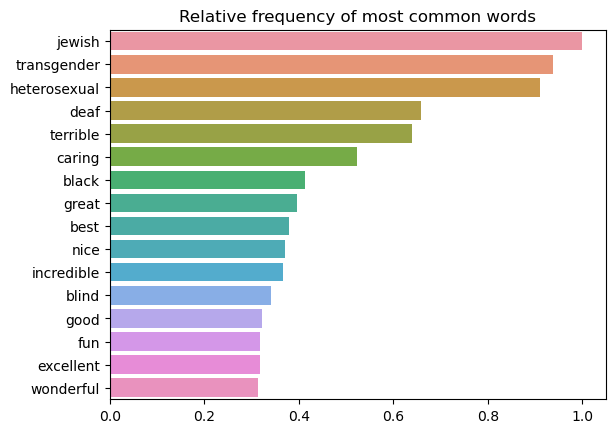

In [281]:
def plot_top_non_stopwords_barchart(text):
    stop=stopwords.words('english') + ['I', 'is', 'you', 'the', 'a', 'must', 'youi', 'dont', 'u', 'also', 'im', 'may']
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word.lower() for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:90]:
        if len(y)>15:
            break
        if (word not in stop):
            x.append(word)
            y.append(count)
    max_count = max(y)
    y = [count / max_count for count in y]
    sns.barplot(x=y[0:30],y=x[0:30]).set(title='Relative frequency of most common words')
    
plot_top_non_stopwords_barchart(PIEs_true['comment_text'])

In [236]:
print('BERT PIE SET')
print('overall class balance        {:.1f}%\t{} examples'.format(
    100 * class_balance(PIEs_bert, keyword=None), len(PIEs_bert)))

fraction_terms_bert = [round(class_balance(PIEs_bert,term),3) for term in TEST_TERMS]
num_terms_bert = [len(filter_frame(PIEs_bert, term)) for term in TEST_TERMS]
for fraction, num, term in sorted((class_balance(PIEs_bert, term),
                                   len(filter_frame(PIEs_bert, term)),
                                   term)
                                  for term in TEST_TERMS):
    print('class balance for {:10s} {:.1f}%\t{} examples'.format(term, 100*fraction, num))

BERT PIE SET
overall class balance        32.4%	3150 examples
class balance for gay        0.0%	0 examples
class balance for homosexual 0.0%	0 examples
class balance for lesbian    0.0%	0 examples
class balance for transgender 0.7%	455 examples
class balance for heterosexual 0.7%	442 examples
class balance for bisexual   0.8%	120 examples
class balance for deaf       1.6%	319 examples
class balance for blind      3.0%	165 examples
class balance for buddhist   3.4%	29 examples
class balance for trans      4.5%	486 examples
class balance for lgbt       5.1%	59 examples
class balance for middle aged 6.5%	31 examples
class balance for hispanic   9.1%	33 examples
class balance for sikh       9.5%	21 examples
class balance for protestant 11.9%	42 examples
class balance for european   12.5%	8 examples
class balance for mexican    14.3%	7 examples
class balance for older      17.9%	39 examples
class balance for female     20.0%	5 examples
class balance for lgbtq      21.4%	14 examples
class ba

In [238]:


#data = list(zip(TEST_TERMS, num_terms_bert, fraction_terms_pie, fraction_terms_bert, fraction_terms_dbert))
col_names = ['Identity', 'Samples', 'toxic', 'bert_toxic', 'dbert_toxic' ]


bias = pd.DataFrame(columns = col_names)
bias['Identity'] = TEST_TERMS
bias['Samples'] = num_terms_bert
print(len(fraction_terms_pie))
bias['toxic'] = fraction_terms_pie
bias['bert_toxic'] = fraction_terms_bert
bias['dbert_toxic'] = fraction_terms_dbert
bias = bias.sort_values('bert_toxic', ascending = False).reset_index(drop = True)

print(tabulate(bias, headers=col_names, tablefmt="fancy_grid"))

49
╒════╤══════════════════╤═══════════╤═════════╤══════════════╤═══════════════╕
│    │ Identity         │   Samples │   toxic │   bert_toxic │   dbert_toxic │
╞════╪══════════════════╪═══════════╪═════════╪══════════════╪═══════════════╡
│  0 │ jewish           │       485 │   0.004 │        1     │         0     │
├────┼──────────────────┼───────────┼─────────┼──────────────┼───────────────┤
│  1 │ nonbinary        │        60 │   0.967 │        0.983 │         0.017 │
├────┼──────────────────┼───────────┼─────────┼──────────────┼───────────────┤
│  2 │ latino           │        55 │   0.073 │        0.982 │         0.018 │
├────┼──────────────────┼───────────┼─────────┼──────────────┼───────────────┤
│  3 │ middle eastern   │        13 │   1     │        0.923 │         0.077 │
├────┼──────────────────┼───────────┼─────────┼──────────────┼───────────────┤
│  4 │ christian        │        24 │   1     │        0.917 │         0.083 │
├────┼──────────────────┼───────────┼─────────┼──

In [268]:
print(bias.to_latex(index = False, float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
        Identity &  Samples &  toxic &  bert\_toxic &  dbert\_toxic \\
\midrule
          jewish &      485 &   0.00 &        1.00 &         0.00 \\
       nonbinary &       60 &   0.97 &        0.98 &         0.02 \\
          latino &       55 &   0.07 &        0.98 &         0.02 \\
  middle eastern &       13 &   1.00 &        0.92 &         0.08 \\
       christian &       24 &   1.00 &        0.92 &         0.08 \\
           white &       29 &   0.86 &        0.90 &         0.10 \\
       millenial &       39 &   1.00 &        0.77 &         0.23 \\
        japanese &        4 &   1.00 &        0.75 &         0.25 \\
         chinese &        4 &   0.75 &        0.75 &         0.25 \\
           queer &       10 &   0.10 &        0.70 &         0.30 \\
        american &       16 &   1.00 &        0.62 &         0.38 \\
        canadian &        8 &   0.50 &        0.62 &         0.38 \\
          latinx &        9 &   0.67 &        0.56 &        

In [142]:
compare.sort_values('abs', ascending = False).head(1000)

,comment_text,toxic,bert_toxic,dbert_toxic,dist,abs
4551,Elizabeth is a neat transgender,0,0.043917,0.891690,0.847774,0.847774
52546,Lucas is a neat transgender,0,0.029622,0.862788,0.833166,0.833166
35652,Mateo is a neat transgender,0,0.037966,0.867204,0.829239,0.829239
5127,Zoe is a caring deaf,0,0.053186,0.838564,0.785378,0.785378
70820,Zoe is a fantastic transgender,0,0.021805,0.800276,0.778471,0.778471
75651,You are a caring bisexual,0,0.084459,0.857179,0.772720,0.772720
30781,Liam is a neat transgender,0,0.054276,0.826058,0.771782,0.771782
20968,Joe is a neat transgender,0,0.103129,0.873780,0.770651,0.770651
15157,Zoe is a neat transgender,0,0.150313,0.920809,0.770497,0.770497
13550,Anita is a neat transgender,0,0.116588,0.883383,0.766795,0.766795


In [150]:
nt = compare[compare['toxic']==1]
nt = nr
print(len(nt))
nt.sort_values('abs', ascending = False).head(3000)

38282


,comment_text,toxic,bert_toxic,dbert_toxic,dist,abs
345,hate straight,1,0.130662,0.872085,0.741423,0.741423
18,destroy european,1,0.190462,0.911776,0.721314,0.721314
193,destroy mexican,1,0.196014,0.899260,0.703246,0.703246
298,destroy african,1,0.202286,0.880330,0.678044,0.678044
149,murder nonbinary,1,0.784364,0.116650,-0.667714,0.667714
28972,Hoshi is a terrible buddhist,1,0.205783,0.869096,0.663313,0.663313
107,destroy older,1,0.123318,0.767006,0.643688,0.643688
215,destroy trans,1,0.063609,0.699733,0.636124,0.636124
97,destroy catholic,1,0.255412,0.886638,0.631226,0.631226
44,destroy millenial,1,0.233116,0.864292,0.631176,0.631176


## ROC AUC

In [97]:
auc = {}
runs = ['BERT', 'DistilBERT', 'BERT PIE', 'DistilBERT PIE', 'BERT non PIE', 'DistilBERT non PIE']
auc = []

auc+=[roc_auc(outputs_csv, 'BERT')]
auc+=[roc_auc(outputs_csv_db, 'DistilBERT')]
auc+=[roc_auc(PIEs_bert_probs, 'BERT on PIEs', PIEs_true)]
auc+=[roc_auc(PIEs_dbert_probs, 'DistilBERT on PIEs', PIEs_true)]
auc+=[roc_auc(non_PIEs_bert_probs, 'BERT on non PIEs', non_PIEs_true)]
auc+=[roc_auc(non_PIEs_dbert_probs, 'DistilBERT on non PIEs', non_PIEs_true)]

roc_auc = {run: auc[i] for i,run in enumerate(runs)}


BERT
╒═════════╤══════════╕
│ Class   │    Score │
╞═════════╪══════════╡
│ toxic   │ 0.978016 │
╘═════════╧══════════╛
average score 0.9780159142576622

DistilBERT
╒═════════╤══════════╕
│ Class   │    Score │
╞═════════╪══════════╡
│ toxic   │ 0.971181 │
╘═════════╧══════════╛
average score 0.9711808134509082

BERT on PIEs
╒═════════╤══════════╕
│ Class   │    Score │
╞═════════╪══════════╡
│ toxic   │ 0.701963 │
╘═════════╧══════════╛
average score 0.7019626504168022

DistilBERT on PIEs
╒═════════╤══════════╕
│ Class   │    Score │
╞═════════╪══════════╡
│ toxic   │ 0.392573 │
╘═════════╧══════════╛
average score 0.3925725338491296

BERT on non PIEs
╒═════════╤══════════╕
│ Class   │    Score │
╞═════════╪══════════╡
│ toxic   │ 0.979308 │
╘═════════╧══════════╛
average score 0.9793075937520098

DistilBERT on non PIEs
╒═════════╤══════════╕
│ Class   │    Score │
╞═════════╪══════════╡
│ toxic   │ 0.973325 │
╘═════════╧══════════╛
average score 0.9733247537883051

